In [117]:
import pandas as pd
import vcfpy
from SigProfilerAssignment import Analyzer as Analyze
import musical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import shutil
import ast
from tqdm import tqdm 
import re
import sys
from scipy import stats
from contextlib import redirect_stdout
from tabulate import tabulate
import csv
pd.set_option("display.max_columns", None)
%matplotlib inline

# Functions

In [249]:
def read_vcf(record):
    return {
        "Chromosome": record.CHROM,
        "Position": record.POS,
        "ID": record.ID,
        "Reference Allele": record.REF,
        "Alternate Alleles": record.ALT,
        "Quality Score": record.QUAL,
        "Info": record.INFO
    }

def dict_to_vcf_INFO(d):
    parts = []
    for k, v in d.items():
        if isinstance(v, list):
            v_str = ','.join(str(i) for i in v)
        else:
            v_str = str(v)
        parts.append(f"{k}:{v_str}")
    return ';'.join(parts)

def INFO_field_to_dict(s):
    d = {}
    for item in s.split(';'):
        if not item:
            continue
        key, val = item.split(':', 1)
        if ',' in val:
            val_list = val.split(',')
            # Try to infer types (int, float)
            try:
                val_list = [x for x in val_list]
            except:
                pass
            d[key] = val_list
        else:
            # Try to infer scalar types
            if val == 'TRUE':
                d[key] = True
            elif val == 'FALSE':
                d[key] = False
            else:
                try:
                    d[key] = int(val)
                except ValueError:
                    try:
                        d[key] = float(val)
                    except ValueError:
                        d[key] = val
    return d

def vcf_to_dataframe(vcf_file):
    data = []
    with open(vcf_file, 'r') as f:
        reader = vcfpy.Reader.from_stream(f)
        for record in reader:
            data.append(read_vcf(record))
    return pd.DataFrame(data)

def dataframe_to_vcf(dataframe, output_vcf):
    # Select columns up to and including 'INFO'
    selected_columns = dataframe.columns[:dataframe.columns.get_loc('INFO')+1]
    dataframe_selected = dataframe[selected_columns].copy()

    # Apply dict_to_INFO_field to the 'INFO' column
    dataframe_selected['INFO'] = dataframe_selected['INFO'].apply(dict_to_vcf_INFO)

    # Write header to VCF file
    header = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tINFO\n"
    with open(output_vcf, 'w') as vcf:
        vcf.write(header)

    # Append DataFrame to VCF file in VCF format
    dataframe_selected.to_csv(output_vcf, sep="\t", mode='a', index=False, header=False)

def process_vcf_dataframe(df, time_analysis=False):
    # Rename columns to match the VCF format
    df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'INFO']
    #sample['INFO'] = sample['INFO'].apply(INFO_field_to_dict)
    df['ID'] = df['ID'].apply(lambda x: x[0] if len(x) != 0 else '.')
    df['ALT'] = df['ALT'].apply(lambda x: x[0].value)

    # Helper to extract INFO fields with a default value of '.'
    def extract_info_field(info, field, default='.'):
        return info.get(field, default)

    # Extract relevant fields from INFO
    info_fields = ['MajCN', 'MinCN', 'MutCN', 'context', 'CLS', 'inWGDregion', 'powr']
    for field in info_fields:
        df[field] = df['INFO'].apply(lambda info: extract_info_field(info, field))

    # Clean 'CLS' column
    df['CLS'] = df['CLS'].apply(lambda x: ''.join(re.findall(r"\[(.+?)\]", x)))

    # Filter rows based on conditions
    df = df[(df['context'] != '.') & (df['CLS'] != '')]
    
    # Filtering for timing analysis
    if time_analysis:
        df = df[df['MajCN'] == 2]
        df = df[df['inWGDregion'] == 'TRUE']

    df.rename(columns={'powr': 'pow'}, inplace=True)

    return df

def process_vcfs_early_late(input_folder, output_folder, organ_csv_path, time_analysis=False, verbose=False):
    """
    Process all VCF files in the input folder and save the processed files in the output folder.

    Args:
    - input_folder (str): Path to the folder containing VCF files.
    - output_folder (str): Path to the folder where processed VCF files will be saved.
    - organ_csv_path (str): Path to the CSV file containing organ information.
    - time_analysis (bool): If True, create a 'timing' folder; otherwise, create 'all_mut' folder.
    """
    
    organ_df = pd.read_csv(organ_csv_path)
    organ_lookup = organ_df.set_index('aliquot_id')['organ'].to_dict()

    # Predefine output folders for each organ and CLS type
    organ_folders = {
        organ: {
            "timing" if time_analysis else "all_mut": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut"),
            "Early": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut", "Early"),
            "Late": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut", "Late"),
            "NA": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut", "NA")
        }
        for organ in organ_df['organ'].unique()
    }
    
    # Create all required folders
    for folders in organ_folders.values():
        for folder in folders.values():
            os.makedirs(folder, exist_ok=True)

    # Process VCF files in the input folder
    for filename in tqdm([f for f in os.listdir(input_folder) if f.endswith(".vcf")], desc="Processing VCFs"):
        vcf_path = os.path.join(input_folder, filename)
        aliquot_id = filename.split(".")[0]
        organ = organ_lookup.get(aliquot_id)

        if not organ:
            #print(f"Organ information not found for {filename}, skipping.")
            continue

        # Process VCF
        sample = vcf_to_dataframe(vcf_path)
        if time_analysis:
            sample = process_vcf_dataframe(sample, time_analysis=True)
        else:
            sample = process_vcf_dataframe(sample)

        cls_groups = {
            "Early": sample[sample['CLS'] == 'early'],
            "Late": sample[sample['CLS'] == 'late'],
            "NA": sample[sample['CLS'] == 'NA']
        }

        for cls, df in cls_groups.items():
            if not df.empty:
                output_vcf = os.path.join(organ_folders[organ]["timing" if time_analysis else "all_mut"], cls, f"{aliquot_id}_{cls.lower()}.vcf")
                dataframe_to_vcf(df, output_vcf)

def save_probabilities(H_reduced_normalized, W_reduced, output_dir):
    # Create a directory to store probability files if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for col_name in H_reduced_normalized.columns:
        # Create an empty DataFrame with the dimensions of W
        result = pd.DataFrame(np.zeros((1, len(W_reduced.columns))), columns=W_reduced.columns)
        col_to_multiply = H_reduced_normalized[col_name]

        # Perform element-wise multiplication for each row in W with the selected column from H
        result = W_reduced.mul(col_to_multiply, axis=1)
        probabilities = result.div(result.sum(axis=1), axis=0)

        output_file = os.path.join(output_dir, f'prob_{col_name}.txt')
        probabilities.to_csv(output_file, sep='\t', index=True)

def calculate_exposures(activities_file, mutation_file, tumor_type, output_folder):
    """
    Process data and run the MuSiCal algorithm, then save the results as CSV files.
    
    Args:
    - activities_file (str): Path to the activities file (CSV format).
    - mutation_file (str): Path to the mutation file (CSV format).
    - tumor_type (str): Tumor type for restricting the catalog.
    - parent_folder (str): Path to the parent folder where CSV files will be saved.
    
    Returns:
    - exposures (DataFrame): The exposures dataframe from SigProfiler.
    - H1 (DataFrame): The exposures dataframe from MuSiCal naive method.
    - H2 (DataFrame): The exposures dataframe from MuSiCal likelihood method.
    - model2.H_reduced_normalized (DataFrame): The normalized exposures from MuSiCal likelihood reduced model.
    """
    
    # Read Activities file
    exposures = pd.read_csv(activities_file, delimiter='\t', index_col=0)
    colnames = exposures.index.tolist()
    exposures = exposures.T
    exposures.columns = colnames
 
    mutation_matrix = pd.read_csv(mutation_file, delimiter='\t', index_col=0)
    numeric_cols = mutation_matrix.select_dtypes(include=['number']).columns
    numeric_cols_filtered = [col for col in numeric_cols if not all(mutation_matrix[col] == 0)]

    mutation_matrix = mutation_matrix[numeric_cols_filtered]
    
    # Musical
    catalog = musical.load_catalog('COSMIC_v3p2_SBS_WGS')
    catalog.restrict_catalog(tumor_type=tumor_type, is_MMRD=False, is_PPD=False)
    W = catalog.W

    # Refit with different methods
    W = W.reindex(mutation_matrix.index)

    H1, model1 = musical.refit.refit(mutation_matrix, W, method='thresh_naive', thresh=0)
    H1.columns = colnames

    H2, model2 = musical.refit.refit(mutation_matrix, W, method='likelihood_bidirectional', thresh=0.001)
    H2.columns = colnames

    # Create the parent folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Save the DataFrames to CSV files within the parent folder
    exposures.to_csv(os.path.join(output_folder, "exposures_SigProfiler.csv"))
    H1.to_csv(os.path.join(output_folder, "exposures_MuSiCal_naive.csv"))
    H2.to_csv(os.path.join(output_folder, "exposures_MuSiCal_lik.csv"))
    model2.H_reduced_normalized.to_csv(os.path.join(output_folder, "exposures_MuSiCal_lik_reduced_norm.csv"))
    model2.W_reduced.to_csv(os.path.join(output_folder, "W_MuSiCal_lik_reduced_norm.csv"))

    return model2.H_reduced_normalized, model2.W_reduced

def run_Signature_Analysis(parent_folder, genome_build):
    """
    Perform COSMIC FIT analysis and MuSiCal analysis for each subfolder in the given parent folder.
    
    Args:
    - parent_folder (str): Path to the parent folder that contains subfolders 'Early', 'Late', 'NA'.
    """
    subfolders = ['Early', 'Late', 'NA']
    
    # Iterate through subfolders
    for subfolder in subfolders:
        subfolder_path = os.path.join(parent_folder, subfolder)
        output_path = os.path.join(parent_folder, subfolder + '/Alexandrov/')
        
        Analyze.cosmic_fit(subfolder_path, output_path,
                                   input_type="vcf", context_type="96",
                                   collapse_to_SBS96=False, cosmic_version=3.2, exome=False,
                                   genome_build=genome_build,
                                   signature_database='breast_sig_db.txt',
                                   exclude_signature_subgroups=None, export_probabilities=False,
                                   export_probabilities_per_mutation=False, make_plots=False,
                                   sample_reconstruction_plots=False, verbose=False)

        # Process data and run musical for the subfolder
        H_reduced_normalized, W_reduced = calculate_exposures(
            os.path.join(output_path, 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt'),
            os.path.join(parent_folder, subfolder + '/output/SBS/Input_vcffiles.SBS96.all'),
            tumor_type='Breast.AdenoCA',
            output_folder=os.path.join(parent_folder, 'SignatureFitting', subfolder, 'exposures')
        )

        # Apply save_probabilities function
        save_probabilities(H_reduced_normalized, W_reduced, 
                           output_dir=os.path.join(parent_folder, 'SignatureFitting', subfolder, 'probabilities'))
        
def prepare_samples_for_timing(vcf_folder_path):
    """
    Reads SNV files from the specified folder path, extracts SBS96 information,
    and adds corresponding information from probabilities based on SBS96 as well as
    MutCN, MinCN, MajCN values.

    Parameters:
        vcf_folder_path (str): Path to the folder containing SNV files (VCFs).

    Returns:
        dict or None: Dictionary of DataFrames containing SBS96 information and added probabilities,
                      where keys are sample IDs and values are DataFrames,
                      if valid files are found, otherwise returns None.
    """
    # Initialize an empty dictionary to store DataFrames for each sample
    sample_dfs = {}

    # Iterate over each subfolder
    for subfolder in ['Early', 'Late', 'NA']:
        print(f'Processing {subfolder} samples:')
        subfolder_path = os.path.join(vcf_folder_path, subfolder)
        if os.path.exists(subfolder_path):
            # Use list comprehension to get the VCF files within the subfolder
            files_to_process = [filename for filename in os.listdir(subfolder_path) if filename.endswith(".vcf")]

            # Use tqdm to create a progress bar for the loop
            for filename in tqdm(files_to_process, desc="Processing Files", unit="file"):
                # Extract sample ID from the VCF file name
                sample_id = filename.split('_')[0]

                # Initialize DataFrame for the sample if not already present
                if sample_id not in sample_dfs:
                    sample_dfs[sample_id] = pd.DataFrame()

                # Construct the full path to the VCF file
                vcf_file_path = os.path.join(subfolder_path, filename)

                # Check if the file is empty
                if os.path.getsize(vcf_file_path) == 0:
                    #print(f"VCF file {filename} is empty. Skipping...")
                    continue

                # Read the VCF file into a DataFrame, skipping lines starting with '#'
                try:
                    vcf_df = pd.read_csv(vcf_file_path, sep='\t', header=None, comment='#')
                except pd.errors.EmptyDataError:
                    #print(f"No data found in VCF file {filename}. Skipping...")
                    continue

                # Extract required columns from the VCF DataFrame
                extracted_df = vcf_df[[0, 1, 3, 4, 6]].copy()  # Assuming CHROM, POS, REF, ALT, INFO are in columns 0, 1, 3, 4, 7

                # Rename columns
                extracted_df.columns = ['CHROM', 'POS', 'REF', 'ALT', 'INFO']

                # Modify CHROM column
                extracted_df['CHROM'] = extracted_df['CHROM'].astype(str)

                # Extract 'SBS96' from 'INFO' column
                def extract_context(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('context')

                def extract_MajCN(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('MajCN')

                def extract_MinCN(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('MinCN')

                def extract_MutCN(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('MutCN')
                
                def extract_pSingle(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('pSingle')
        
                def extract_pGain(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('pGain')
                
                def extract_pow(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('powr')
                
                def extract_VAF(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('VAF')

                extracted_df['SBS96'] = extracted_df['INFO'].apply(extract_context)
                extracted_df['MajCN'] = extracted_df['INFO'].apply(extract_MajCN)
                extracted_df['MinCN'] = extracted_df['INFO'].apply(extract_MinCN)
                extracted_df['MutCN'] = extracted_df['INFO'].apply(extract_MutCN)
                extracted_df['pSingle'] = extracted_df['INFO'].apply(extract_pSingle)
                extracted_df['pGain'] = extracted_df['INFO'].apply(extract_pGain)
                #extracted_df['pow'] = extracted_df['INFO'].apply(extract_pow)
                extracted_df['VAF'] = extracted_df['INFO'].apply(extract_VAF)

                # Add a column for classification
                extracted_df['Classification'] = subfolder

                probabilities_folder = os.path.join(subfolder_path, "probabilities")
                probabilities_file = os.path.join(probabilities_folder, f'prob_{sample_id}_{subfolder.lower()}.txt')
                if os.path.exists(probabilities_file):
                    probabilities_df = pd.read_csv(probabilities_file, sep='\t', index_col=0)
                    for index, row in extracted_df.iterrows():
                        sbs96_value = row['SBS96']
                        if sbs96_value in probabilities_df.index:
                            for col in probabilities_df.columns:
                                extracted_df.at[index, f'prob_{col}'] = probabilities_df.at[sbs96_value, col]

                # Append extracted DataFrame to the sample's DataFrame
                sample_dfs[sample_id] = pd.concat([sample_dfs[sample_id], extracted_df], ignore_index=True)
        else:
            print(f"Subfolder {subfolder} not found.")

    # Check if any valid DataFrames were found
    if sample_dfs:
        return sample_dfs
    else:
        print("No valid files found.")
        return None

def prepare_samples_for_timing(vcf_folder_path):
    """
    Processes SNV files, extracts SBS96 context, and appends relevant mutation information for each sample.

    Args:
        vcf_folder_path (str): Path to folder containing SNV files.

    Returns:
        dict: Dictionary of DataFrames with sample IDs as keys, containing SBS96 info and probabilities.
    """
    def extract_info(info_str, key):
        """ Extract a value from the INFO field in VCF data. """
        try:
            info_dict = ast.literal_eval(info_str)
            return info_dict.get(key)
        except (ValueError, SyntaxError):
            return None
        
    def extract_info(info_str, key):
        return info_str.get(key, None)

    # Initialize result dictionary
    sample_dfs = {}

    # Iterate over subfolders
    for subfolder in ['Early', 'Late', 'NA']:
        subfolder_path = os.path.join(vcf_folder_path, subfolder)
        if not os.path.exists(subfolder_path): continue

        print(f'Processing {subfolder} samples:')

        # Process VCF files
        for filename in tqdm([f for f in os.listdir(subfolder_path) if f.endswith(".vcf")], desc="Processing Files"):
            sample_id = filename.split('_')[0]
            vcf_file_path = os.path.join(subfolder_path, filename)

            # Skip empty VCF files
            if os.path.getsize(vcf_file_path) == 0: continue

            # Read VCF file and extract necessary info
            try:
                vcf_df = pd.read_csv(vcf_file_path, sep='\t', header=None, comment='#')
            except pd.errors.EmptyDataError:
                continue
            
            extracted_df = vcf_df[[0, 1, 3, 4, 6]].copy()  # Extract relevant columns
            extracted_df.columns = ['CHROM', 'POS', 'REF', 'ALT', 'INFO']
            extracted_df['INFO'] = extracted_df['INFO'].apply(INFO_field_to_dict)
            extracted_df['CHROM'] = extracted_df['CHROM'].astype(str)

            # Apply extraction functions to extract mutation data
            extracted_df['SBS96'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'context'))
            extracted_df['MajCN'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'MajCN'))
            extracted_df['MinCN'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'MinCN'))
            extracted_df['MutCN'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'MutCN'))
            extracted_df['pSingle'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'pSingle'))
            extracted_df['pGain'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'pGain'))
            extracted_df['VAF'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'VAF'))

            # Add classification column based on subfolder
            extracted_df['Classification'] = subfolder

            # Load probabilities and merge with the extracted data
            probabilities_file = os.path.join(vcf_folder_path, "SignatureFitting", subfolder, "probabilities", f'prob_{sample_id}_{subfolder.lower()}.txt')
            if os.path.exists(probabilities_file):
                probabilities_df = pd.read_csv(probabilities_file, sep='\t', index_col=0)
                for index, row in extracted_df.iterrows():
                    sbs96_value = row['SBS96']
                    if sbs96_value in probabilities_df.index:
                        for col in probabilities_df.columns:
                            extracted_df.at[index, f'prob_{col}'] = probabilities_df.at[sbs96_value, col]

            # Append to the sample's DataFrame or initialize it if not present
            if sample_id not in sample_dfs:
                sample_dfs[sample_id] = extracted_df
            else:
                sample_dfs[sample_id] = pd.concat([sample_dfs[sample_id], extracted_df], ignore_index=True)

    # Return the result dictionary if data is found, otherwise None
    return sample_dfs if sample_dfs else None

def calculate_WGDtime_prob_bootstrapping(sample_df, num_bootstrap=200, sample_fraction=1):
    # Keep [C>T]pG mutations
    sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]

    N_mut_CpG_all = np.array([])
    for min_cn in range(3):
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_CpG_all = np.append(N_mut_CpG_all, filtered_df.shape[0])

    weighted_means = np.array([])
    # Perform bootstrap sampling
    for _ in range(num_bootstrap):
        # Sample data with replacement
        bootstrap_sample = sample_df.sample(frac=sample_fraction, replace=True)
        t_values_bootstrap = np.array([])
        N_mut_CpG = np.array([])
        
        for min_cn in range(3):
            filtered_df = bootstrap_sample[bootstrap_sample['MinCN'] == min_cn]

            N_mut_CpG = np.append(N_mut_CpG, filtered_df.shape[0])

            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['prob_SBS1'] * row['pSingle'] / (row['pSingle'] + row['pGain'])
                sum_pi += row['prob_SBS1']
            pi_1 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate pi_2
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['prob_SBS1'] * row['pGain'] / (row['pSingle'] + row['pGain'])
                sum_pi += row['prob_SBS1']
            pi_2 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate t_value based on MinCN
            if pi_2 == 0 and pi_1 != 0:
                t_value = 0
            elif pi_1 + 2 * pi_2 == 0:
                t_value = np.nan
            else:
                t_value = (3 * pi_2) / (pi_1 + 2 * pi_2) if min_cn == 1 else (2 * pi_2) / (pi_1 + 2 * pi_2)

            t_values_bootstrap = np.append(t_values_bootstrap,t_value)
            
        nan_indices = np.isnan(t_values_bootstrap)
        
        if np.sum(nan_indices) == 1:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = np.sum(non_nan_means * non_nan_weights) / np.sum(non_nan_weights)
        elif np.sum(nan_indices) == 2:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = non_nan_means[0]
        else:
            weighted_mean = np.sum(t_values_bootstrap * N_mut_CpG) / np.sum(N_mut_CpG)

        weighted_means = np.append(weighted_means,weighted_mean)

    WGD_time = np.mean(weighted_means)

    # Calculate the 95th percentile CI
    lower_bound = np.percentile(weighted_means, 2.5)
    upper_bound = np.percentile(weighted_means, 97.5)
    WDG_time_CI = (upper_bound - lower_bound)/2

    return N_mut_CpG_all, weighted_means, WGD_time, WDG_time_CI

def calculate_HRD_time(sample_df):
    # Initialize result variables
    t_values_dict = {0: None, 1: None, 2: None}
    N_mut_dict = {0: None, 1: None, 2: None}
    pi_2_SBS1_val = {0: None, 1:None, 2:None}
    pi_2_SBS3_val = {0: None, 1:None, 2:None}
    pi_1_SBS1_val = {0: None, 1:None, 2:None}
    pi_1_SBS3_val = {0: None, 1:None, 2:None}
    c_dict = {0: None, 1: None, 2: None}
    c_avg_values = {0: None, 2: None}
    Nt_SBS1_val = {0: None, 1:None, 2:None}
    Nt_SBS3_val = {0: None, 1:None, 2:None}
    c_avg = 0

    # Define the order of MinCN values
    min_cn_order = [0, 2, 1]

    # Loop through MinCN values in the specified order
    for min_cn in min_cn_order:
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_dict[min_cn] = filtered_df.shape[0]

        # Calculate pi_1 and pi_2 for SBS1
        sum_num_SBS1 = 0
        sum_pi_SBS1 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS1 += row['prob_SBS1'] * row['pSingle'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS1 += row['prob_SBS1']
        pi_1_SBS1 = sum_num_SBS1 / sum_pi_SBS1 if sum_pi_SBS1 != 0 else np.nan

        sum_num_SBS1 = 0
        sum_pi_SBS1 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS1 += row['prob_SBS1'] * row['pGain'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS1 += row['prob_SBS1']
        pi_2_SBS1 = sum_num_SBS1 / sum_pi_SBS1 if sum_pi_SBS1 != 0 else np.nan

        # Calculate pi_1 and pi_2 for SBS3
        sum_num_SBS3 = 0
        sum_pi_SBS3 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS3 += row['prob_SBS3'] * row['pSingle'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS3 += row['prob_SBS3']
        pi_1_SBS3 = sum_num_SBS3 / sum_pi_SBS3 if sum_pi_SBS3 != 0 else np.nan

        sum_num_SBS3 = 0
        sum_pi_SBS3 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS3 += row['prob_SBS3'] * row['pGain'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS3 += row['prob_SBS3']
        pi_2_SBS3 = sum_num_SBS3 / sum_pi_SBS3 if sum_pi_SBS3 != 0 else np.nan

        Nt_SBS1 = np.sum(filtered_df['prob_SBS1'].tolist())
        Nt_SBS3 = np.sum(filtered_df['prob_SBS3'].tolist())

        # Adjust pi_2 for SBS1 using the new formula
        pi_2_SBS1_prime = pi_2_SBS1 - (pi_2_SBS3 / pi_1_SBS3) * pi_1_SBS1 if pi_1_SBS3 != 0 else np.nan

        # Calculate t_value based on MinCN using the adjusted pi_2_SBS1_prime
        if (pi_1_SBS1 + 2 * pi_2_SBS1_prime == 0) or np.isnan(pi_2_SBS1_prime):
            t_value = np.nan
        else:
            t_value = (3 * pi_2_SBS1_prime) / (pi_1_SBS1 + 2 * pi_2_SBS1) if min_cn == 1 else (2 * pi_2_SBS1_prime) / (pi_1_SBS1 + 2 * pi_2_SBS1)

        t_values_dict[min_cn] = t_value

        if min_cn == 0 or min_cn == 2:
            c_dict[min_cn] = (pi_1_SBS1 * Nt_SBS1) / (pi_1_SBS3 * Nt_SBS3)
            c_avg_values[min_cn] = c_dict[min_cn]

        # Calculate weighted average of c for min_cn 0 and 2
        if min_cn == 2:
            c_avg_numerator = 0
            c_avg_denominator = 0
            if c_avg_values[0] is not None:
                c_avg_numerator += c_avg_values[0] * N_mut_dict[0]
                c_avg_denominator += N_mut_dict[0]
            if c_avg_values[2] is not None:
                c_avg_numerator += c_avg_values[2] * N_mut_dict[2]
                c_avg_denominator += N_mut_dict[2]
            if c_avg_denominator != 0:
                c_avg = c_avg_numerator / c_avg_denominator

        if min_cn == 1:
            # Recalculate pi_2_SBS1_prime using the weighted average c0
            pi_2_SBS1_prime = pi_2_SBS1 - pi_2_SBS3 * c_avg * (Nt_SBS3 / Nt_SBS1) if pi_1_SBS3 != 0 else np.nan
            # Recalculate t_value for min_cn 1 using the adjusted pi_2_SBS1_prime
            if (pi_1_SBS1 + 2 * pi_2_SBS1_prime == 0) or np.isnan(pi_2_SBS1_prime):
                t_value = np.nan
            else:
                t_value = (3 * pi_2_SBS1_prime) / (pi_1_SBS1 + 2 * pi_2_SBS1)
            t_values_dict[min_cn] = t_value

        pi_2_SBS1_val[min_cn] = pi_2_SBS1
        pi_2_SBS3_val[min_cn] = pi_2_SBS3
        pi_1_SBS1_val[min_cn] = pi_1_SBS1
        pi_1_SBS3_val[min_cn] = pi_1_SBS3
        Nt_SBS1_val[min_cn] = Nt_SBS1
        Nt_SBS3_val[min_cn] = Nt_SBS3


    # Arrange the results in the order 0, 1, 2
    t_values = [t_values_dict[0], t_values_dict[1], t_values_dict[2]]
    N_mut = [N_mut_dict[0], N_mut_dict[1], N_mut_dict[2]]
    c = [c_dict[0], c_dict[1], c_dict[2]]
    pi_2_SBS1_values = [pi_2_SBS1_val[0], pi_2_SBS1_val[1], pi_2_SBS1_val[2]]
    pi_2_SBS3_values = [pi_2_SBS3_val[0], pi_2_SBS3_val[1], pi_2_SBS3_val[2]]
    pi_1_SBS1_values = [pi_1_SBS1_val[0], pi_1_SBS1_val[1], pi_1_SBS1_val[2]]
    pi_1_SBS3_values = [pi_1_SBS3_val[0], pi_1_SBS3_val[1], pi_1_SBS3_val[2]]
    Nt_SBS1_values = [Nt_SBS1_val[0], Nt_SBS1_val[1], Nt_SBS1_val[2]]
    Nt_SBS3_values = [Nt_SBS3_val[0], Nt_SBS3_val[1], Nt_SBS3_val[2]]

    return t_values, N_mut, c_avg, c, pi_2_SBS1_values, pi_2_SBS3_values, Nt_SBS1_values, Nt_SBS3_values, pi_1_SBS1_values, pi_1_SBS3_values

def calculate_HRDtime_prob_bootstrapping(sample_df, num_bootstrap=200, sample_fraction=1):
    # Filter the DataFrame based on the 'SBS96' column values
    # sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]

    HRD_means = np.array([])
    pi_2_SBS1 = {min_cn: [] for min_cn in range(3)}
    pi_2_SBS3 = {min_cn: [] for min_cn in range(3)}
    pi_1_SBS1 = {min_cn: [] for min_cn in range(3)}
    pi_1_SBS3 = {min_cn: [] for min_cn in range(3)}
    c_val = {min_cn: [] for min_cn in range(3)}
    c_avg_val = np.array([])
    Nt_SBS1 = {min_cn: [] for min_cn in range(3)}
    Nt_SBS3 = {min_cn: [] for min_cn in range(3)}

    N_mut_all = np.array([])
    for min_cn in range(3):
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_all = np.append(N_mut_all, filtered_df.shape[0])

    # Perform bootstrap sampling
    for _ in range(num_bootstrap):
        # Sample data with replacement
        bootstrap_sample = sample_df.sample(frac=sample_fraction, replace=True)

        t_values, N_mut, cavg, c, pi2SBS1, pi2SBS3, NtSBS1, NtSBS3, pi1SBS1, pi1SBS3= calculate_HRD_time(bootstrap_sample)

        t_values = np.array(t_values)
        N_mut = np.array(N_mut)
        nan_indices = np.isnan(t_values)

        if np.sum(nan_indices) == 1:
            non_nan_means = t_values[~nan_indices]
            non_nan_weights = N_mut[~nan_indices]
            weighted_mean = np.sum(non_nan_means * non_nan_weights) / np.sum(non_nan_weights)
        elif np.sum(nan_indices) == 2:
            non_nan_means = t_values[~nan_indices]
            non_nan_weights = N_mut[~nan_indices]
            weighted_mean = non_nan_means[0]
        else:
            weighted_mean = np.sum(t_values * N_mut) / np.sum(N_mut)

        HRD_means = np.append(HRD_means,weighted_mean)

        for min_cn in range(3):
            pi_2_SBS1[min_cn].append(pi2SBS1[min_cn])
            pi_2_SBS3[min_cn].append(pi2SBS3[min_cn])
            pi_1_SBS1[min_cn].append(pi1SBS1[min_cn])
            pi_1_SBS3[min_cn].append(pi1SBS3[min_cn])
            Nt_SBS1[min_cn].append(NtSBS1[min_cn])
            Nt_SBS3[min_cn].append(NtSBS3[min_cn])
            c_val[min_cn].append(c[min_cn])

        c_avg_val = np.append(c_avg_val, cavg)

    HRD_time = np.mean(HRD_means)

    # Calculate the 95th percentile CI
    lower_bound = np.percentile(HRD_means, 2.5)
    upper_bound = np.percentile(HRD_means, 97.5)
    HRD_time_CI = (upper_bound - lower_bound)/2
            
    # Assuming gauss_means and gauss_4stds are lists of lists and initialized elsewhere
    pi_2_SBS1_mean = [[] for _ in range(3)]
    pi_2_SBS3_mean = [[] for _ in range(3)]
    pi_1_SBS1_mean = [[] for _ in range(3)]
    pi_1_SBS3_mean = [[] for _ in range(3)]
    pi_2_SBS1_err = [[] for _ in range(3)]
    pi_2_SBS3_err = [[] for _ in range(3)]
    pi_1_SBS1_err = [[] for _ in range(3)]
    pi_1_SBS3_err = [[] for _ in range(3)]
    Nt_SBS1_mean = [[] for _ in range(3)]
    Nt_SBS3_mean = [[] for _ in range(3)]
    c_val_mean = [[] for _ in range(3)]

    for i in range(3):
        if i == 1:
            c_val_mean[i] = 0
        else:
            c_val_mean[i] = np.mean(c_val[i])
        pi_2_SBS1_mean[i] = np.mean(pi_2_SBS1[i])
        pi_2_SBS1_err[i] = np.std(pi_2_SBS1[i])
        pi_2_SBS3_mean[i] = np.mean(pi_2_SBS3[i])
        pi_2_SBS3_err[i] = np.std(pi_2_SBS3[i])
        pi_1_SBS1_mean[i] = np.mean(pi_1_SBS1[i])
        pi_1_SBS1_err[i] = np.std(pi_1_SBS1[i])
        pi_1_SBS3_mean[i] = np.mean(pi_1_SBS3[i])
        pi_1_SBS3_err[i] = np.std(pi_1_SBS3[i])
        Nt_SBS1_mean[i] = np.mean(Nt_SBS1[i])
        Nt_SBS3_mean[i] = np.mean(Nt_SBS3[i])

    c_avg = np.mean(c_avg_val)

    return N_mut_all, HRD_means, HRD_time, HRD_time_CI, c_val_mean, c_avg, Nt_SBS1_mean, Nt_SBS3_mean, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err

def calculate_WGDtime_CTpGs(sample_df, N_mut_CpGs):
        sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]
        t_values = []
        
        for min_cn in range(3):
            filtered_df = sample_df[sample_df['MinCN'] == min_cn]

            # Calculate pi_1
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pSingle'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
                #row['prob_SBS1']
            pi_1 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate pi_2
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pGain'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
            pi_2 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate t_value based on MinCN
            if pi_2 == 0 and pi_1 != 0:
                t_value = 0
            elif pi_1 + 2 * pi_2 == 0:
                t_value = np.nan
            else:
                t_value = (3 * pi_2) / (pi_1 + 2 * pi_2) if min_cn == 1 else (2 * pi_2) / (pi_1 + 2 * pi_2)

            t_values.append(t_value)
        

        # Convert t_values to a Pandas Series to use fillna()
        df_values_filled = pd.Series(t_values).fillna(0)
        
        # Ensure N_mut_CpGs is also a Pandas Series
        df_weights_filled = pd.Series(N_mut_CpGs).fillna(0)

        # Normalize the weights for each row
        normalized_weights = df_weights_filled.div(df_weights_filled.sum(), axis=0)
        
        # Calculate the weighted mean
        weighted_means = (df_values_filled * normalized_weights)

        return weighted_means.to_dict()

def calculate_WGDtime_prob_bootstrapping_CTpG(sample_df, num_bootstrap=200, sample_fraction=1):
    # Keep [C>T]pG mutations
    sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]

    N_mut_CpG_all = np.array([])
    for min_cn in range(3):
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_CpG_all = np.append(N_mut_CpG_all, filtered_df.shape[0])

    weighted_means = np.array([])
    # Perform bootstrap sampling
    for _ in range(num_bootstrap):
        # Sample data with replacement
        bootstrap_sample = sample_df.sample(frac=sample_fraction, replace=True)
        t_values_bootstrap = np.array([])
        N_mut_CpG = np.array([])
        
        for min_cn in range(3):
            filtered_df = bootstrap_sample[bootstrap_sample['MinCN'] == min_cn]

            N_mut_CpG = np.append(N_mut_CpG, filtered_df.shape[0])

            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pSingle'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
            pi_1 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate pi_2
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pGain'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
            pi_2 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate t_value based on MinCN
            if pi_2 == 0 and pi_1 != 0:
                t_value = 0
            elif pi_1 + 2 * pi_2 == 0:
                t_value = np.nan
            else:
                t_value = (3 * pi_2) / (pi_1 + 2 * pi_2) if min_cn == 1 else (2 * pi_2) / (pi_1 + 2 * pi_2)

            t_values_bootstrap = np.append(t_values_bootstrap,t_value)
            
        nan_indices = np.isnan(t_values_bootstrap)
        
        if np.sum(nan_indices) == 1:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = np.sum(non_nan_means * non_nan_weights) / np.sum(non_nan_weights)
        elif np.sum(nan_indices) == 2:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = non_nan_means[0]
        else:
            weighted_mean = np.sum(t_values_bootstrap * N_mut_CpG) / np.sum(N_mut_CpG)

        weighted_means = np.append(weighted_means,weighted_mean)

    WGD_time = np.mean(weighted_means)

    # Calculate the 95th percentile CI
    lower_bound = np.percentile(weighted_means, 2.5)
    upper_bound = np.percentile(weighted_means, 97.5)
    WDG_time_CI = (upper_bound - lower_bound)/2

    return N_mut_CpG_all, weighted_means, WGD_time, WDG_time_CI

# PCAWG

## 0. Preprocess TimeR Output / Split vcfs early - late

In [125]:
input_folder_path = "PCAWG/hrdtimer_results_v3"
output_folder_path = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2"
organ_csv_path = "breast_ovarian_summary_with_age.csv"

# Ensure the output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=False)
process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=True)

Processing VCFs: 100%|██████████| 317/317 [01:36<00:00,  3.28it/s]


## 1. Breast Cancer Samples

### 1.2 Signature fitting / probability of mutation-attribution to Signatures

In [250]:
all_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/all_mut/"
timing_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/timing/"
run_Signature_Analysis(all_muts, genome_build="GRCh37")
run_Signature_Analysis(timing_muts, genome_build="GRCh37")

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 9.57 seconds.
Matrices generated for 207 samples with 0 errors. Total of 297191 SNVs, 1323 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 207/207 [100%] in 4.4s (46.90/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 6.01 seconds.
Matrices generated for 184 samples with 0 errors. Total of 292648 SNVs, 1584 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 184/184 [100%] in 4.3s (42.66/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 16.55 seconds.
Matrices generated for 208 samples with 0 errors. Total

### 1.3 Prepare / load required data to run timing

In [183]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/timing"
breast_samples = prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 202/202 [00:21<00:00,  9.48it/s]


Processing Late samples:


Processing Files: 100%|██████████| 174/174 [00:22<00:00,  7.79it/s]


Processing NA samples:


Processing Files: 100%|██████████| 205/205 [00:18<00:00, 11.04it/s]


In [184]:
# Read the CSV file into a DataFrame
breast_metadata_path = 'breast_ovarian_summary_with_age_hrd_grade.csv'
breast_metadata = pd.read_csv(breast_metadata_path)
breast_samples_list = list(breast_samples.keys()) # From vcf files
breast_samples_metadata_df = breast_metadata[breast_metadata['aliquot_id'].isin(breast_samples_list)]
#WGD
#Keep only samples with WGD
breast_samples_metadata_df = breast_samples_metadata_df[breast_samples_metadata_df['WGD'] == True]
breast_samples_WGD_IDs = breast_samples_metadata_df['aliquot_id'].tolist()
#HRD
HRD_WGD_breast_samples_IDs = breast_metadata.loc[
    (breast_metadata['isHRD']) & 
    (breast_metadata['organ.x'] == 'Breast') & 
    (breast_metadata['WGD'] == True), 
    'aliquot_id'
]
HRD_samples = HRD_WGD_breast_samples_IDs.tolist()

In [185]:
# For timing analysis keep samples with WGD only
breast_samples_WGD = {key: breast_samples[key] for key in breast_samples_WGD_IDs if key in breast_samples}
breast_samples_WGD_HRD = {key: breast_samples[key] for key in HRD_samples if key in breast_samples}

### 1.4 Timing Analysis

In [186]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    #WGD_Time_CpGs = calculate_WGDtime_CTpGs(sample_df, N_mut_CpG)
    #WGDTime_CpGs[sample_id] = WGD_Time_CpGs
    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI

Processing Samples: 100%|██████████| 34/34 [01:53<00:00,  3.34s/it]


Best-fit line (through origin): y = 0.974 * x
Chi-squared: 9.330
Reduced Chi-squared: 0.283


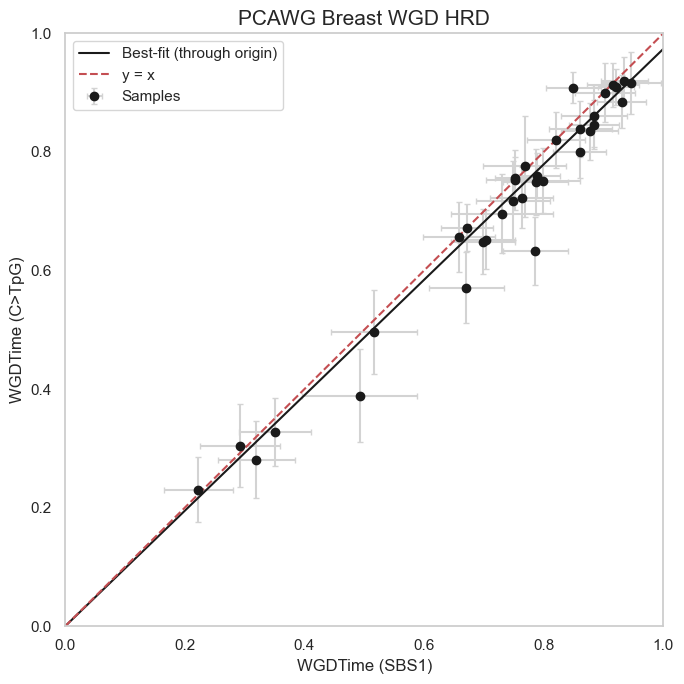

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import odr

# Combine into a DataFrame
df = pd.DataFrame({
    "WGDTime_mean": pd.Series(WGDTime_means),
    "WGDTime_mean_error": pd.Series(WGDTime_error),
    "WGDTime_CpG": pd.Series(WGDTime_CpGs),
    "WGDTime_CpG_error": pd.Series(WGDTime_CpGs_error),
})

# Drop NaNs
df = df.dropna()

# Define model (force intercept to 0)
def linear_through_origin(B, x):
    return B[0] * x

model = odr.Model(linear_through_origin)

# Create data object with errors
data = odr.RealData(
    df["WGDTime_mean"],
    df["WGDTime_CpG"],
    sx=df["WGDTime_mean_error"],
    sy=df["WGDTime_CpG_error"]
)

# Run ODR
odr_instance = odr.ODR(data, model, beta0=[1.])
output = odr_instance.run()

# Extract values
slope = output.beta[0]
chi2 = output.sum_square  # Chi-squared
dof = len(df) - 1  # degrees of freedom = n - number of fitted params
reduced_chi2 = chi2 / dof

# Print results
print(f"Best-fit line (through origin): y = {slope:.3f} * x")
print(f"Chi-squared: {chi2:.3f}")
print(f"Reduced Chi-squared: {reduced_chi2:.3f}")

# Plot
plt.figure(figsize=(7, 7))
plt.errorbar(
    df["WGDTime_mean"],
    df["WGDTime_CpG"],
    xerr=df["WGDTime_mean_error"],
    yerr=df["WGDTime_CpG_error"],
    fmt='o',
    color='k',
    ecolor='lightgrey',
    capsize=2,
    label='Samples'
)

# Best-fit line
x_vals = np.linspace(0, 1, 100)
y_vals = slope * x_vals
plt.plot(x_vals, y_vals, 'k-', label='Best-fit (through origin)')

# Reference line
plt.plot([0,1], [0,1], 'r--', label='y = x')

# Annotate chi-squared on plot
#plt.text(0.05, 0.9, f"$\\chi^2$ = {chi2:.3f}\nReduced $\\chi^2$ = {reduced_chi2:.3f}", fontsize=10)

# Aesthetics
plt.xlabel("WGDTime (SBS1)")
plt.ylabel("WGDTime (C>TpG)")
plt.title("PCAWG Breast WGD HRD", fontsize=15)
plt.grid(False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.legend()
plt.show()


From the above plot the outlier that the time is pushed earlier in the SBS1 prob formula is interesting. This sample is an APOBEC sample. Signature exposures show that APOBEC is active early in the sample. From the calculation of probabilities, several contexts such as the TCG>T are assigned almost by 0.98 percent to originate from APOBEC in such a sample and not from a timing process. Hence if we naively took all C>Ts at CG contexts, we would overestimate the proportion of early timing mutations and that would push the timing estimate higher. This is effect is corrected with this new approach

In [187]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 34/34 [36:36<00:00, 64.60s/it]


In [188]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in HRD_samples:
    if aliquot_id in breast_samples:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")

        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg, wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('PCAWG_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)

+--------------------------------------+------------+--------------+-----------+--------------+---------------+-------------------+-----------------------------------------------------------------+--------------------------------------------------------------------+--------------------------------------------------------------------+-----------------------------------------------------------------------+-----------------------------------------------------------------+--------------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------------+-------------------------------------------------+-----------+--------------------------------------------------------------+--------------------------------------------------------------+-----------------------+---------------------------+
| ID                                   |    HRDTime |   HRDTime_ci |   WGDTime | 

## 2. Ovary Cancer Samples

### 2.1 Signature fitting / probability of mutation-attribution to Signatures

In [210]:
all_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Ovary/all_mut/"
timing_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Ovary/timing/"
run_Signature_Analysis(all_muts, genome_build="GRCh37")
run_Signature_Analysis(timing_muts, genome_build="GRCh37")

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 4.14 seconds.
Matrices generated for 109 samples with 0 errors. Total of 173590 SNVs, 1059 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 109/109 [100%] in 2.7s (40.82/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 7.02 seconds.
Matrices generated for 107 samples with 0 errors. Total of 243193 SNVs, 1844 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 107/107 [100%] in 2.5s (43.13/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 11.97 seconds.
Matrices generated for 109 samples with 0 errors. Total

### 2.2 Prepare / load required data to run timing

In [211]:
vcf_folder_path = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Ovary/timing"
ovary_samples = prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 109/109 [00:11<00:00,  9.66it/s]


Processing Late samples:


Processing Files: 100%|██████████| 107/107 [00:17<00:00,  6.07it/s]


Processing NA samples:


Processing Files: 100%|██████████| 109/109 [00:14<00:00,  7.78it/s]


In [212]:
# Read the CSV file into a DataFrame
ovary_metadata_path = 'breast_ovarian_summary_with_age_hrd_grade.csv'
ovary_metadata = pd.read_csv(ovary_metadata_path)
ovary_samples_list = list(ovary_samples.keys()) # From vcf files
ovary_samples_metadata_df = ovary_metadata[ovary_metadata['aliquot_id'].isin(ovary_samples_list)]
#WGD
#Keep only samples with WGD
ovary_samples_metadata_df = ovary_samples_metadata_df[ovary_samples_metadata_df['WGD'] == True]
ovary_samples_WGD_IDs = ovary_samples_metadata_df['aliquot_id'].tolist()
#HRD
HRD_WGD_ovary_samples_IDs = ovary_metadata.loc[
    (ovary_metadata['isHRD']) & 
    (ovary_metadata['organ.x'] == 'Ovary') & 
    (ovary_metadata['WGD'] == True), 
    'aliquot_id'
]
HRD_samples = HRD_WGD_ovary_samples_IDs.tolist()

In [213]:
# For timing analysis keep samples with WGD only
ovary_samples_WGD = {key: ovary_samples[key] for key in ovary_samples_WGD_IDs if key in ovary_samples}
ovary_samples_WGD_HRD = {key: ovary_samples[key] for key in HRD_samples if key in ovary_samples}

In [214]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(ovary_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    #WGD_Time_CpGs = calculate_WGDtime_CTpGs(sample_df, N_mut_CpG)
    #WGDTime_CpGs[sample_id] = WGD_Time_CpGs
    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI

Processing Samples: 100%|██████████| 27/27 [01:47<00:00,  3.98s/it]


In [215]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(ovary_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 27/27 [30:56<00:00, 68.76s/it] 


In [216]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in HRD_samples:
    if aliquot_id in ovary_samples:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")

        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg, wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('PCAWG_Ovary_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)

+--------------------------------------+-----------+--------------+-----------+--------------+---------------+-------------------+-------------------------------------------------------------------+--------------------------------------------------------------------+--------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------+--------------------------------------------------------------------+----------------------------------------------------------------+-----------------------------------------------------------------------+------------------------------------------------+-----------+-------------------------------------------------------------+--------------------------------------------------------------+-----------------------+--------------------------+
| ID                                   |   HRDTime |   HRDTime_ci |   WGDTime |   

# SCANB

In [221]:
SCANB_metadata_path = 'hrdtimer_SCANB_selected.csv'
SCANB_metadata = pd.read_csv(SCANB_metadata_path)
SCANB_metadata['isHRD'] = True
SCANB_metadata['organ'] = 'Breast'
SCANB_metadata['WGD'] = True
SCANB_metadata['aliquot_id'] = SCANB_metadata['SangerID.Tumour']
#output_csv_path = 'SCANB_metadata.csv'  # Replace with your desired output CSV file path
#SCANB_metadata.to_csv(output_csv_path, index=False)

In [222]:
input_folder_path = "SCANB/hrdtimer_results_unfiltered"
output_folder_path = "AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25"
organ_csv_path = "SCANB_metadata.csv"

# Ensure the output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=False)
process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=True)

Processing VCFs: 100%|██████████| 240/240 [00:17<00:00, 13.93it/s]


In [223]:
all_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/all_mut"
timing_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/timing"
run_Signature_Analysis(all_muts, genome_build="GRCh37")
run_Signature_Analysis(timing_muts, genome_build="GRCh37")

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 3.43 seconds.
Matrices generated for 49 samples with 0 errors. Total of 160642 SNVs, 820 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 49/49 [100%] in 1.4s (35.06/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 6.39 seconds.
Matrices generated for 49 samples with 0 errors. Total of 144557 SNVs, 626 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 49/49 [100%] in 1.3s (36.62/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 3.14 seconds.
Matrices generated for 49 samples with 0 errors. Total of 151272

In [224]:
vcf_folder_path = "AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/timing"
breast_samples = prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]


Processing Late samples:


Processing Files: 100%|██████████| 49/49 [00:07<00:00,  6.70it/s]


Processing NA samples:


Processing Files: 100%|██████████| 49/49 [00:06<00:00,  7.91it/s]


In [225]:
WGD_HRD_samples = list(breast_samples.keys())
breast_samples_WGD_HRD = {key: breast_samples[key] for key in WGD_HRD_samples if key in breast_samples}

In [235]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    #WGD_Time_CpGs = calculate_WGDtime_CTpGs(sample_df, N_mut_CpG)
    #WGDTime_CpGs[sample_id] = WGD_Time_CpGs
    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI

Processing Samples: 100%|██████████| 49/49 [02:05<00:00,  2.57s/it]


In [236]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 49/49 [39:31<00:00, 48.39s/it]


In [237]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in breast_samples_WGD_HRD:
    if aliquot_id in breast_samples_WGD_HRD:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")

        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg,  wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('SCANB_unfiltered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)

+----------+------------+--------------+-----------+--------------+---------------+-------------------+-----------------------------------------------------------------+---------------------------------------------------------------------+------------------------------------------------------------------+---------------------------------------------------------------------+------------------------------------------------------------------+---------------------------------------------------------------------+----------------------------------------------------------------+---------------------------------------------------------------------+----------------------------------------------------+-------------+--------------------------------------------------------------+--------------------------------------------------------------+-----------------------+--------------------------+
| ID       |    HRDTime |   HRDTime_ci |   WGDTime |   WGDTime_ci |   WGDTime_CpG |   WGDTime_CpG_err | pi2

# INFORM

## Preprocess metadata

In [239]:
INFORM_metadata_path = 'INFORM2/inform_samples_isWGD.csv'
INFORM_metadata = pd.read_csv(INFORM_metadata_path)
INFORM_metadata['isHRD'] = True
INFORM_metadata['organ'] = 'Breast'
INFORM_metadata['WGD'] = INFORM_metadata['isWGD']
INFORM_metadata['aliquot_id'] = INFORM_metadata['individual_display_title']
output_csv_path = 'INFORM_metadata.csv'  # Replace with your desired output CSV file path
INFORM_metadata.to_csv(output_csv_path, index=False)

In [240]:
input_folder_path = "INFORM_germline_filtered_hrdtimer_vcfs"
output_folder_path = "AA_NEW_TEST_RUN_INFORM_germline_filtered_v2"
organ_csv_path = "INFORM_metadata.csv"

# Ensure the output folder exists
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=False)
process_vcfs_early_late(input_folder_path, output_folder_path, organ_csv_path, time_analysis=True)

Processing VCFs: 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]


In [242]:
all_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/all_mut"
timing_muts = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/timing"
run_Signature_Analysis(all_muts, genome_build="GRCh38")
run_Signature_Analysis(timing_muts, genome_build="GRCh38")

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 1.09 seconds.
Matrices generated for 19 samples with 0 errors. Total of 23861 SNVs, 192 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 19/19 [100%] in 0.5s (36.24/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 1.24 seconds.
Matrices generated for 19 samples with 0 errors. Total of 33051 SNVs, 533 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 19/19 [100%] in 0.5s (35.33/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 2.15 seconds.
Matrices generated for 19 samples with 1 errors. Total of 91900 SN

In [243]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/timing"
breast_samples = prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Processing Late samples:


Processing Files: 100%|██████████| 19/19 [00:02<00:00,  8.34it/s]


Processing NA samples:


Processing Files: 100%|██████████| 19/19 [00:02<00:00,  8.48it/s]


In [245]:
WGD_HRD_samples = ['Patient101','Patient17','Patient18','Patient25','Patient26','Patient33','Patient34','Patient82']
breast_samples_WGD_HRD = {key: breast_samples[key] for key in WGD_HRD_samples if key in breast_samples}

In [246]:
WGDTime_means = {}
WGDTime_CpGs = {}
WGDTime_error = {}
WGDTime_CpGs_error = {}
NmutCpG = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_CpG, _, WDGTime, WGDTime_CI = calculate_WGDtime_prob_bootstrapping(sample_df)
    _, _, WGDTime_CpG, WGDTime_CpG_CI = calculate_WGDtime_prob_bootstrapping_CTpG(sample_df)
    # Store the results for the current sample
    WGDTime_means[sample_id] = WDGTime
    WGDTime_error[sample_id] = WGDTime_CI
    NmutCpG[sample_id] = N_mut_CpG.tolist()

    #WGD_Time_CpGs = calculate_WGDtime_CTpGs(sample_df, N_mut_CpG)
    #WGDTime_CpGs[sample_id] = WGD_Time_CpGs
    WGDTime_CpGs[sample_id] = WGDTime_CpG
    WGDTime_CpGs_error[sample_id] = WGDTime_CpG_CI


Processing Samples: 100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


In [247]:
HRDTime_means = {}
HRDTime_error = {}
pi2SBS1_means = {}
pi2SBS1_err = {}
pi2SBS3_means = {}
pi2SBS3_err = {} 
pi1SBS1_means = {}
pi1SBS1_err = {}
pi1SBS3_means = {}
pi1SBS3_err = {}
c = {}
c_avg = {}
NtSBS1 ={}
NtSBS3 ={}
Nmutall = {}

# Iterate over each sample in the dictionary with a progress bar
for sample_id, sample_df in tqdm(breast_samples_WGD_HRD.items(), desc="Processing Samples"):
    # Calculate bootstrap samples and confidence intervals
    N_mut_all, _, HRD_time, HRD_time_CI, c_val_mean, cavg, Nt_SBS1, Nt_SBS3, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err = calculate_HRDtime_prob_bootstrapping(sample_df)
    # Store the results for the current sample
    HRDTime_means[sample_id] = HRD_time
    HRDTime_error[sample_id] = HRD_time_CI
    pi2SBS1_means[sample_id] = pi_2_SBS1_mean
    pi2SBS1_err[sample_id] = pi_2_SBS1_err
    pi2SBS3_means[sample_id] = pi_2_SBS3_mean
    pi2SBS3_err[sample_id] = pi_2_SBS3_err
    pi1SBS1_means[sample_id] = pi_1_SBS1_mean
    pi1SBS1_err[sample_id] = pi_1_SBS1_err
    pi1SBS3_means[sample_id] = pi_1_SBS3_mean
    pi1SBS3_err[sample_id] = pi_1_SBS3_err
    c[sample_id] = c_val_mean 
    c_avg[sample_id] = cavg
    NtSBS1[sample_id] = Nt_SBS1
    NtSBS3[sample_id] = Nt_SBS3
    Nmutall[sample_id] = N_mut_all.tolist()

Processing Samples: 100%|██████████| 8/8 [07:10<00:00, 53.77s/it]


In [248]:
results = []

# Loop through each filtered ID, calculate HRD time, and store the results
for aliquot_id in breast_samples_WGD_HRD:
    if aliquot_id in breast_samples:
        n_mut_CpG = NmutCpG.get(aliquot_id, "Not available")
        n_mut_all = Nmutall.get(aliquot_id, "Not available")
        
        hrd_time = HRDTime_means.get(aliquot_id, "Not available")
        hrd_time_error = HRDTime_error.get(aliquot_id, "Not available")

        wgd_time = WGDTime_means.get(aliquot_id, "Not available")
        wgd_time_error = WGDTime_error.get(aliquot_id, "Not available")
        
        wgd_time_cpg = WGDTime_CpGs.get(aliquot_id, "Not available")
        wgd_time_cpg_err = WGDTime_CpGs_error.get(aliquot_id, "Not available")

        pi2SBS1_mean = pi2SBS1_means.get(aliquot_id, "Not available")
        pi2SBS1_error = pi2SBS1_err.get(aliquot_id, "Not available")

        pi2SBS3_mean = pi2SBS3_means.get(aliquot_id, "Not available")
        pi2SBS3_error = pi2SBS3_err.get(aliquot_id, "Not available")

        pi1SBS1_mean = pi1SBS1_means.get(aliquot_id, "Not available")
        pi1SBS1_error = pi1SBS1_err.get(aliquot_id, "Not available")

        pi1SBS3_mean = pi1SBS3_means.get(aliquot_id, "Not available")
        pi1SBS3_error = pi1SBS3_err.get(aliquot_id, "Not available")

        C = c.get(aliquot_id, "Not available")
        C_avg = c_avg.get(aliquot_id, "Not available")

        Nt_SBS1 = NtSBS1.get(aliquot_id, "Not available")
        Nt_SBS3 = NtSBS3.get(aliquot_id, "Not available")
        
        results.append([aliquot_id, hrd_time, hrd_time_error, wgd_time, wgd_time_error, wgd_time_cpg, wgd_time_cpg_err, pi2SBS1_mean, pi2SBS1_error, pi2SBS3_mean, pi2SBS3_error, pi1SBS1_mean, pi1SBS1_error, pi1SBS3_mean, pi1SBS3_error, C, C_avg, Nt_SBS1, Nt_SBS3, n_mut_CpG, n_mut_all])

# Print the results as a table
print(tabulate(results, headers=["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"], tablefmt="grid"))

with open('INFORM_germline_filtered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["ID", "HRDTime", "HRDTime_ci", "WGDTime", "WGDTime_ci", "WGDTime_CpG", "WGDTime_CpG_err", 'pi2SBS1' , 'pi2SBS1_ci', 'pi2SBS3' , 'pi2SBS3_ci', 'pi1SBS1' , 'pi1SBS1_ci', 'pi1SBS3' , 'pi1SBS3_ci', "c", "c21", "Nt_SBS1", "Nt_SBS3", "N_mut(C>TpG)", "N_mut_all"])
    # Write the data
    writer.writerows(results)

+------------+------------+--------------+-----------+--------------+---------------+-------------------+-----------------------------------------------------------------+------------------------------------------------------------------+-----------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------------------------------+------------------------------------------------------------------+---------------------------------------------------------------+---------------------------------------------------------------------+------------------------------------------------+-----------+-------------------------------------------------------------+-------------------------------------------------------------+----------------------+--------------------------+
| ID         |    HRDTime |   HRDTime_ci |   WGDTime |   WGDTime_ci |   WGDTime_CpG |   WGDTime_CpG_err | pi2SBS1            

# --------- Example plot to compare WDG Time CpG vs WGD

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import odr

# Combine into a DataFrame
df = pd.DataFrame({
    "WGDTime_mean": pd.Series(WGDTime_means),
    "WGDTime_mean_error": pd.Series(WGDTime_error),
    "WGDTime_CpG": pd.Series(WGDTime_CpGs),
    "WGDTime_CpG_error": pd.Series(WGDTime_CpGs_error),
})

# Drop NaNs
df = df.dropna()

# Define model (force intercept to 0)
def linear_through_origin(B, x):
    return B[0] * x

model = odr.Model(linear_through_origin)

# Create data object with errors
data = odr.RealData(
    df["WGDTime_mean"],
    df["WGDTime_CpG"],
    sx=df["WGDTime_mean_error"],
    sy=df["WGDTime_CpG_error"]
)

# Run ODR
odr_instance = odr.ODR(data, model, beta0=[1.])
output = odr_instance.run()

# Extract values
slope = output.beta[0]
chi2 = output.sum_square  # Chi-squared
dof = len(df) - 1  # degrees of freedom = n - number of fitted params
reduced_chi2 = chi2 / dof

# Print results
print(f"Best-fit line (through origin): y = {slope:.3f} * x")
print(f"Chi-squared: {chi2:.3f}")
print(f"Reduced Chi-squared: {reduced_chi2:.3f}")

# Plot
plt.figure(figsize=(7, 7))
plt.errorbar(
    df["WGDTime_mean"],
    df["WGDTime_CpG"],
    xerr=df["WGDTime_mean_error"],
    yerr=df["WGDTime_CpG_error"],
    fmt='o',
    color='k',
    ecolor='lightgrey',
    capsize=2,
    label='Samples'
)

# Best-fit line
x_vals = np.linspace(0, 1, 100)
y_vals = slope * x_vals
plt.plot(x_vals, y_vals, 'k-', label='Best-fit (through origin)')

# Reference line
plt.plot([0,1], [0,1], 'r--', label='y = x')

# Annotate chi-squared on plot
#plt.text(0.05, 0.9, f"$\\chi^2$ = {chi2:.3f}\nReduced $\\chi^2$ = {reduced_chi2:.3f}", fontsize=10)

# Aesthetics
plt.xlabel("WGDTime (SBS1)")
plt.ylabel("WGDTime (C>TpG)")
plt.title("PCAWG Breast WGD HRD", fontsize=15)
plt.grid(False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.legend()
plt.show()
